In [14]:
import os
import csv
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import data
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from  sklearn.metrics.pairwise import cosine_similarity
from random import sample

In [2]:
data_path = "data/negotiate"
lines = []
file_name = os.path.join(data_path, 'data.txt')
with open(file_name, 'r') as f:
    for line in f:
        lines.append(line.strip())
g =  [line[:12] for line in lines]
o =  [line[-12:] for line in lines]
selection = [line[12:-12].split('<eos>')[-2].split('<selection>')[1] for line in lines]
rew = [line[12:-12].split('<eos>')[-1][8:] for line in lines]
dialog = [line[12:-12].split('<eos>')[:-2] for line in lines]

In [3]:
df = pd.DataFrame({'g':g, 'dialog':dialog, 'selection':selection, 'reward':rew, 'outcome':o})
df.head()
df.to_csv("nego_games.csv", index=False)

In [4]:
deals = [s.strip() != 'no agreement' for s in selection]

In [7]:
df['books']  = [g.split()[0] for g in df['g']]
df['hats']  = [g.split()[2] for g in df['g']]
df['balls']  = [g.split()[4] for g in df['g']]



In [11]:
sents = []

for d in df['dialog']:
    for sent in d:
        s = sent.strip()
        if s[:3] == 'YOU':
            sents.append(s[4:].strip())

In [12]:
with open('sent.txt', 'w') as f:
    for s in sents:
        f.write(s +'\n')

In [13]:
df = pd.DataFrame({"sentences":sents})

In [15]:
partial = pd.read_csv("dataset100.csv", index_col=0)


In [16]:
partial

,sentences,greeting,need:books,need:hats,need:balls,offer:books,offer:hats,offer:balls,inquiry,agreement
index,,,,,,,,,,
0,i would like 4 hats and you can have the rest .,False,NaN,4,NaN,all,0,all,NaN,NaN
1,deal,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Full
2,you can have all the hats if i get the book an...,False,1,NaN,all,NaN,all,NaN,NaN,NaN
3,hi i would like the book and ball and you can ...,True,1,NaN,1,NaN,all,NaN,NaN,NaN
4,ill take the book,False,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
30529,take all the balls rest for me i guess,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30530,mmk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30531,sold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Embeddings

In [17]:

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(partial['sentences'], show_progress_bar=True)

Batches:   0%|          | 0/955 [00:00<?, ?it/s]

In [18]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

C:\Users\ravy\Anaconda3\envs\py30\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [19]:
cluster = hdbscan.HDBSCAN(min_cluster_size=100,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

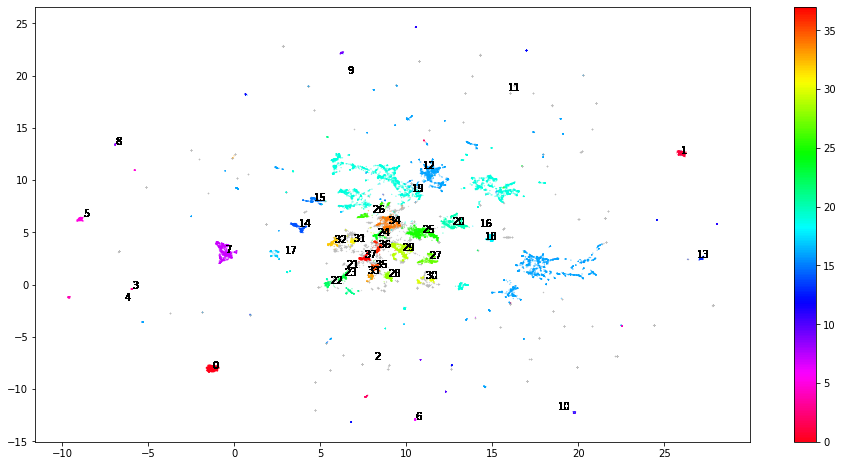

In [20]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(16, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
for i in clustered.labels:
    plt.annotate(i, (np.mean(clustered[clustered['labels'] == i].x),  np.mean(clustered[clustered['labels'] == i].y)))
plt.colorbar()

In [22]:
docs_df = pd.DataFrame(list(partial['sentences']), columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [23]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(partial['sentences']))

In [24]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out ()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

In [25]:
n_merge = 20
for i in range(n_merge):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(partial['sentences'])
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)

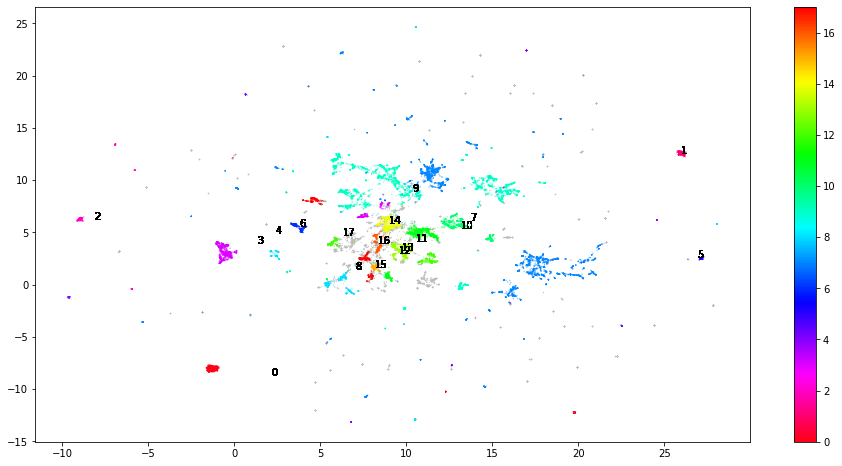

In [26]:
# Prepare data
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = docs_df.Topic

# Visualize clusters
fig, ax = plt.subplots(figsize=(16, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
for i in clustered.labels:
    plt.annotate(i, (np.mean(clustered[clustered['labels'] == i].x),  np.mean(clustered[clustered['labels'] == i].y)))
plt.colorbar()

In [27]:
topic_sizes.head(10)

,Topic,Size
10,9,5678
0,-1,5624
8,7,4997
4,3,1702
12,11,1586
1,0,1491
11,10,1226
14,13,1070
9,8,1048
3,2,872


In [28]:
sent_df = pd.DataFrame({"text":partial['sentences'], "cluster":cluster.labels_})

In [29]:
def get_examples(df, clusters,  n=10):
    examples = dict()
    for c in clusters:
        cluster_examples = list()
        cluster_examples.extend(sample(list(df[df['cluster'] == c].text),n))
        examples[c] = cluster_examples
    return examples

In [30]:
top_n = 20
examples = get_examples(sent_df, topic_sizes['Topic'][1:top_n+1])
print(f"Top {top_n} Largest Clusters: Random Example Messages")
for k in examples.keys():
    print("#"*30 + "\n")
    print(f"Sample messages for cluster {k}:\n")
    [print(m) for m in examples[k]]
    print("\n")

Top 20 Largest Clusters: Random Example Messages
##############################

Sample messages for cluster -1:

i can take both books , smiles
i have to have book . you can have the rest .
i want both books for sure , and ideally all the balls . what do you want ?
okay great ! thank you !
we seem to have reached an impasse then . i need that book .
if i can have the hats and the book you can have the balls
can i just take all books ?
fine
fine
all books to me , you get rest


##############################

Sample messages for cluster 7:

you can have the hat if i can have the ball and 3 books
i'd like the hat and the balls ; you can keep all 3 books ?
if you want the ball , then i want 3 hats and the book .
that won't work for me . i will be well under in points . i tried to concede already by taking just 1 ball and 1 book ; that's the best i am willing to go in this situtuation . unless you want the book and the hats and give me all 3 balls .
can i have the book and 3 balls .
ok ho

In [34]:
partial['cluster'] = sent_df['cluster']

In [240]:
partial = pd.read_csv("dataset_clustered.csv", index_col = 0)

In [239]:
partial2 = partial

In [241]:
#partial.to_csv("dataset_clustered.csv")
partial.head()

,sentences,greeting,need:books,need:hats,need:balls,offer:books,offer:hats,offer:balls,inquiry,agreement,thanks,same,annotated,cluster
index,,,,,,,,,,,,,,
12316,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,16
7922,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,19
13776,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,19
21820,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,19
1611,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,7


# Cluster 0

In [242]:
(partial[partial['cluster'] == 0].sentences).value_counts()


deal    1236
bet        1
Name: sentences, dtype: int64

In [93]:
partial.loc[partial.sentences == 'deal', 'agreement'] = 'Full'

partial.loc[partial.sentences == 'okay deal .', 'agreement'] = 'Full'
partial.loc[partial.sentences == 'agreed', 'agreement'] = 'Full'


# Cluster 1

In [94]:
(partial[partial['cluster'] == 1].sentences).value_counts()


no deal                   797
no deal thn                 1
ouch , no deal              1
alas , no deal              1
bet no deal                 1
not possible , no deal      1
there is no deal here       1
no deal : /                 1
Name: sentences, dtype: int64

Entire cluster is a variant of "NO DEAL"

In [95]:
partial.loc[partial.cluster == 1, 'agreement'] = 'No Deal'
partial.loc[partial.cluster == 1, 'annotated'] = True

# Cluster 2

In [96]:
(partial[partial['cluster'] == 2].sentences).value_counts()

no               71
no .              5
nah               4
how about no      3
no ?              2
yeah no           2
no , for me .     1
no ,              1
haha no           1
no . choose .     1
nah son           1
um , no           1
lol . no .        1
no it's not       1
no thats it       1
no nice           1
no how            1
nohat             1
gov't             1
lol no            1
then no .         1
no d 3 eal        1
Name: sentences, dtype: int64

In [97]:
partial.loc[partial.cluster == 2, 'agreement'] = 'No Deal'
partial.loc[partial.cluster == 2, 'annotated'] = True

# Cluster 3

In [98]:
(partial[partial['cluster'] == 3].sentences).value_counts()


ok deal    134
Name: sentences, dtype: int64

In [99]:
partial.loc[partial.cluster == 3, 'agreement'] = 'Full'
partial.loc[partial.cluster == 3, 'annotated'] = True

# Cluster 4

In [100]:
(partial[partial['cluster'] == 4].sentences).value_counts()

okay         195
ok deal .     22
Name: sentences, dtype: int64

In [101]:
partial.loc[partial.cluster == 4, 'agreement'] = 'Full'
partial.loc[partial.cluster == 4, 'annotated'] = True

# Cluster 5

In [102]:
(partial[partial['cluster'] == 5].sentences).value_counts()

ok       603
yup       32
yup !      1
Name: sentences, dtype: int64

In [103]:
partial.loc[partial.cluster == 5, 'agreement'] = 'Full'
partial.loc[partial.cluster == 5, 'annotated'] = True

# Cluster 6

In [104]:
(partial[partial['cluster'] == 6].sentences).value_counts()

what would you like       119
ok what would you like      2
what do you like            1
what would you like .       1
ok what do you like         1
Name: sentences, dtype: int64

In [105]:
partial.loc[partial.cluster == 6, 'inquiry'] = True
partial.loc[partial.cluster == 6, 'annotated'] = True

# Cluster 7 - Not Simple

In [106]:
(partial[partial['cluster'] == 7].sentences).value_counts()

you can have 3 balls                                                          4
how about you get three books                                                 3
how about i take 3 books and you take the rest ?                              2
if i can have one of each you can have the other three balls                  2
3 books                                                                       2
                                                                             ..
could i have the hat and ball ? and you can take all three books              1
hi there ! i'd really be happiest if i can have all 3 books and the ball .    1
i would like three hats and the book .                                        1
three balls                                                                   1
so i get 3 hats and 2 balls ?                                                 1
Name: sentences, Length: 1310, dtype: int64

# Cluster 8

In [107]:
(partial[partial['cluster'] == 8].sentences).value_counts()

ok deal     100
mmm deal      1
ok dealz      1
Name: sentences, dtype: int64

In [108]:
partial.loc[partial.cluster == 8, 'agreement'] = 'Full'
partial.loc[partial.cluster == 8, 'annotated'] = True

# Cluster 9

In [109]:
(partial[partial['cluster'] == 9].sentences).value_counts()

yes                       258
thank you .                18
yes !                       2
indeed                      2
yes please . thank you      1
how about yes               1
yes ?                       1
yes yes                     1
yess                        1
Name: sentences, dtype: int64

In [110]:
partial.loc[partial.cluster == 9, 'agreement'] = 'Full'
partial.loc[partial.cluster == 9, 'annotated'] = True

# Cluster 10 - Mixed

In [111]:
(partial[partial['cluster'] == 10].sentences).value_counts()

no deal .          216
hello               26
. no deal            3
hello .              2
no deal it is .      2
hello !              2
no deal is it .      1
hello /              1
hello ,              1
Name: sentences, dtype: int64

In [112]:
partial.loc[(partial.cluster == 10)  & (partial.sentences.str.contains('no', regex=False)), 'agreement'] = 'No Deal' 
partial.loc[(partial.cluster == 10)  & (partial.sentences.str.contains('no', regex=False)), 'annotated'] = True 

In [113]:
# Cluster 11

In [114]:
(partial[partial['cluster'] == 11].sentences).value_counts()

agreed                  62
hi                      28
agree                    9
hi !                     2
agreed upon              1
hi ,                     1
hi there                 1
hi .                     1
ok , if you insist .     1
Name: sentences, dtype: int64

In [115]:
partial.loc[partial.sentences == 'agreed', 'agreement'] = 'Full'
partial.loc[partial.sentences == 'agreed', 'annotated'] = True
partial.loc[partial.sentences == 'agree', 'agreement'] = 'Full'
partial.loc[partial.sentences == 'agree', 'annotated'] = True
partial.loc[partial.sentences == 'agreed upon', 'agreement'] = 'Full'
partial.loc[partial.sentences == 'agreed upon', 'annotated'] = True

In [117]:
# Cluster 12

In [118]:
(partial[partial['cluster'] == 12].sentences).value_counts()

thanks                69
okay deal .           65
thank you !           33
okay , deal           10
ok thanks              9
okay , deal .          8
thanks .               6
ok , thanks            4
alright , deal .       3
okay thanks .          1
yep , thanks           1
fine , thanks          1
okay deal : )          1
ok i appreciate it     1
got it thanks          1
same , thanks          1
okay thanks            1
okay , thanks .        1
ok . thanks            1
yes , thanks           1
alright deal .         1
deal . take care .     1
done thankls           1
thanks : )             1
Name: sentences, dtype: int64

In [119]:
partial.loc[partial.cluster == 12, 'agreement'] = 'Full'
partial.loc[partial.cluster == 12, 'annotated'] = True

In [120]:
# Cluster 13

In [121]:
(partial[partial['cluster'] == 13].sentences).value_counts()

deal .                                   428
deal then                                  4
k deal                                     3
sold                                       2
fari deal .                                1
deal ,                                     1
deall                                      1
ni deal                                    1
lno deal                                   1
how about a million dollars with that      1
negotiation time                           1
kk ! deal                                  1
sold and done .                            1
8 points                                   1
Name: sentences, dtype: int64

In [122]:
(partial[partial['cluster'] == 14].sentences).value_counts()

i would like the hat and all the books you can have the basketball               2
i will give you all hats and a book , if i can have all of the basketballs .     2
what about basketballs ?                                                         2
i'd like the hats and the basketball ; are the books of high value to you ?      2
i would like the hat and basketball you can have all the books                   2
                                                                                ..
i will take the basketballs and the book you can have the hat                    1
no deal i will take the book and 1 hat you can have 2 hats and the basketball    1
i'd like the basketball and book if you want the hats                            1
i would like the basketballs and hats . you can have the books                   1
i'd like 1 basketball and 1 book , you can have the rest .                       1
Name: sentences, Length: 490, dtype: int64

In [123]:
(partial[partial['cluster'] == 15].sentences).value_counts()

balls and hats for me                          7
give me hat and balls                          7
hats and balls for me                          5
give me hat and ball                           4
give me the hat and balls                      3
                                              ..
huh ? you can have both hats and both balls    1
i'll give you the ball and hat . . .           1
ball and all the hats                          1
hat and balls to me                            1
the hats and the balls ?                       1
Name: sentences, Length: 292, dtype: int64

In [124]:
(partial[partial['cluster'] == 16].sentences).value_counts()

yes .                                  44
yep                                    43
ok .                                   27
okay .                                 25
then no deal                           22
                                       ..
shoot . how we gonna do this then ?     1
they're worthless to me too .           1
no i cannot agree to that               1
ok . i will take that                   1
it's a deal ?                           1
Name: sentences, Length: 3444, dtype: int64

In [125]:
(partial[partial['cluster'] == 17].sentences).value_counts()

i would like the hat and the balls .                              13
i would like the hat and the ball .                               12
i would like the hats and the balls .                             11
i would like the hats and the ball .                              10
i would like the balls and the hat .                               7
                                                                  ..
i'd like the hat , myself . i'd settle for the hat and balls .     1
i'm okay with the hats but i think i'd like at least one ball      1
i'd like the balls and hat .                                       1
i'd like the ball and hat .                                        1
i'd rather like the hat also . i can let you have the ball .       1
Name: sentences, Length: 115, dtype: int64

In [126]:
(partial[partial['cluster'] == 18].sentences).value_counts()

books and hats                                 6
give me hat and books                          5
give me the hat and books                      4
book and hats                                  3
can i have the hats and a book please ?        3
                                              ..
take the hats and a book                       1
you get both books and a hat                   1
both hats and a book and we have a deal        1
okay so i take the book and both hats          1
would you accept a book for the other hat ?    1
Name: sentences, Length: 277, dtype: int64

In [127]:
(partial[partial['cluster'] == 19].sentences).value_counts()

i need the ball                                                                     18
i need the hat                                                                      16
i need the ball and 2 hats                                                          12
i just want the ball                                                                11
one ball                                                                            10
                                                                                    ..
i really only need the hat and one ball sir .                                        1
the ball is worth more for me . but you can have the ball and i`ll take the rest     1
i want the ball and one hat                                                          1
i need the hats and you can have the rest                                            1
take all the balls rest for me i guess                                               1
Name: sentences, Length: 5008, dtype: int64

In [224]:
(partial[partial['cluster'] == 20].sentences).value_counts()

i need the book and 2 hats               9
i want the hat and two books             7
i would like 2 books and 1 hat           6
i need the hat and 2 books               6
i need the book and two hats             5
                                        ..
ok , so two hats and two books for me    1
two books and two hats                   1
two hats and and one book for you        1
yeah how about two books only            1
i'd like the book and two hats           1
Name: sentences, Length: 818, dtype: int64

# Most common un-annotated messages

In [243]:
(partial[partial.annotated == False].sentences).value_counts()[:10]

i need the ball                         18
i need the book                         16
i need the hat                          16
i would like the books and the hat .    14
correct                                 14
i would like the hat and the balls .    13
i want one of each .                    13
one hat                                 12
i would like the hat and the ball .     12
i just want the book                    12
Name: sentences, dtype: int64

In [218]:
agree_phrases = ['deal .', 'ok .', 'ok , deal', 'ok , deal .', 'okay great !', 'cool', 'i can do that', 'agreed .', 'i agree .', 'great ! thank you !', 'great !', 'okay .', 'sounds good', 'sounds good .', 'sure', 'great', 'okay deal', 'okay thank you !', 'okay deal', 'fine', 'yes .', 'yep', 'deal !', 'okay great ! thank you !']
for phrase in agree_phrases:
    partial.loc[partial.sentences == phrase, 'agreement'] = 'Full'
    partial.loc[partial.sentences == phrase, 'annotated'] = True

In [226]:
disagree_phrases = ['nope', 'no deal then', 'ok no deal', 'okay no deal .', 'nd', 'no deal then .', 'agreed . no deal .', 'ok , no deal', 'no way', 
                    'never', 'sorry no deal', 'then no deal', 'no can do', "i can't do that"]
for phrase in disagree_phrases:
    partial.loc[partial.sentences == phrase, 'agreement'] = 'No Deal'
    partial.loc[partial.sentences == phrase, 'annotated'] = True


In [203]:
greeting_phrases = ['hi', 'hello']
for phrase in greeting_phrases:
    partial.loc[partial.sentences == phrase, 'greeting'] = True
    partial.loc[partial.sentences == phrase, 'annotated'] = True

In [204]:
question_phrases = ['what would you like ?', 'what do you want ?' ]
for phrase in question_phrases:
    partial.loc[partial.sentences == phrase, 'inquiry'] = True
    partial.loc[partial.sentences == phrase, 'annotated'] = True

In [205]:
thank_phrases = ['thanks', 'thanks !', 'thank you', 'thx']
for phrase in thank_phrases:
    partial.loc[partial.sentences == phrase, 'agreement'] = 'Full'
    partial.loc[partial.sentences == phrase, 'thanks'] = True
    partial.loc[partial.sentences == phrase, 'annotated'] = True

In [223]:
similar_phrases = ['same', 'me too', 'same here']
for phrase in similar_phrases:
    partial.loc[partial.sentences == phrase, 'same'] = True
    partial.loc[partial.sentences == phrase, 'annotated'] = True

In [132]:
partial.loc[partial.sentences.str.contains('hello'), 'greeting'] = True

In [136]:
partial.loc[partial.sentences.str.contains('hi '), 'greeting'] = True

In [237]:
partial.to_csv("dataset_clustered.csv")

In [244]:
partial.annotated.mean()

0.20059605685465381